In [1]:
pip install pandas

     |████████████████████████████████| 10.4MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 512kB 43.4MB/s eta 0:00:01
     |████████████████████████████████| 20.3MB 26.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

     |████████████████████████████████| 6.7MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 25.2MB 33.6MB/s eta 0:00:01
     |████████████████████████████████| 296kB 34.8MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

     |████████████████████████████████| 215kB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 13.1MB 47.6MB/s eta 0:00:01
     |████████████████████████████████| 92kB 27.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 22.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pyspark

     |████████████████████████████████| 215.7MB 55.1MB/s eta 0:00:01
     |████████████████████████████████| 204kB 30.8MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
  Found existing installation: py4j 0.10.8.1
    Uninstalling py4j-0.10.8.1:
      Successfully uninstalled py4j-0.10.8.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pydoop

     |████████████████████████████████| 675kB 3.4MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/1e/ae/7e/98da92f40ed64fe3da73ec7c5ca2babd1bbfd4aa74ea0b7071
Successfully built pydoop
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"
os.environ['JAVA_HOME'] = "/usr/local/java/jdk1.8.0_221"

In [2]:
from __future__ import print_function

import sys
if sys.version >= '3':
    long = int

from pyspark.sql import SparkSession

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import MatrixFactorizationModel
from pyspark.sql import Row
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import json

In [3]:
import pydoop.hdfs as pyhdfs
import time

In [4]:
import os
import subprocess

cmd = 'hdfs dfs -ls /tmp'
subprocess.check_output(cmd, shell=True)

b'Found 3 items\n-rw-r--r--   2 root supergroup    3286722 2019-10-10 21:37 /tmp/books.hdfs.csv\ndrwx-wx-wx   - root supergroup          0 2019-09-04 12:52 /tmp/hive\n-rw-r--r--   2 root supergroup   12437766 2019-10-10 21:38 /tmp/ratings.hdfs.csv\n'

In [5]:
# Reference: https://community.cloudera.com/t5/Community-Articles/Interacting-with-Hadoop-HDFS-using-Python-codes/ta-p/245163
def run_cmd(args_list):
        """
        run linux commands
        """
        # import subprocess
        print('Running system command: {0}'.format(' '.join(args_list)))
        proc = subprocess.Popen(args_list, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        s_output, s_err = proc.communicate()
        s_return =  proc.returncode
        return s_return, s_output, s_err 

In [6]:
(ret, out, err)= run_cmd(['hdfs', 'dfs', '-copyToLocal', 'hdfs:/tmp/books.hdfs.csv', 'books.csv'])

Running system command: hdfs dfs -copyToLocal hdfs:/tmp/books.hdfs.csv books.csv


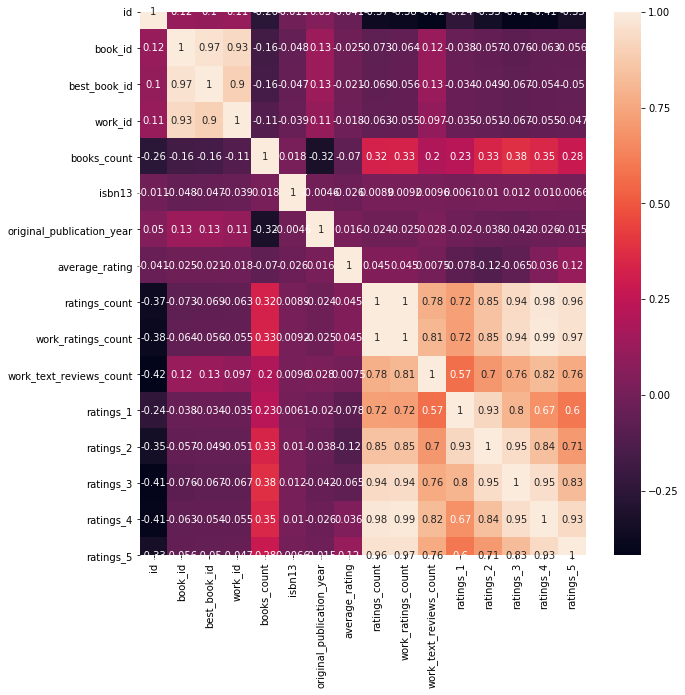

In [33]:
df = pd.read_csv("books.csv")
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True,ax=ax)
plt.show()

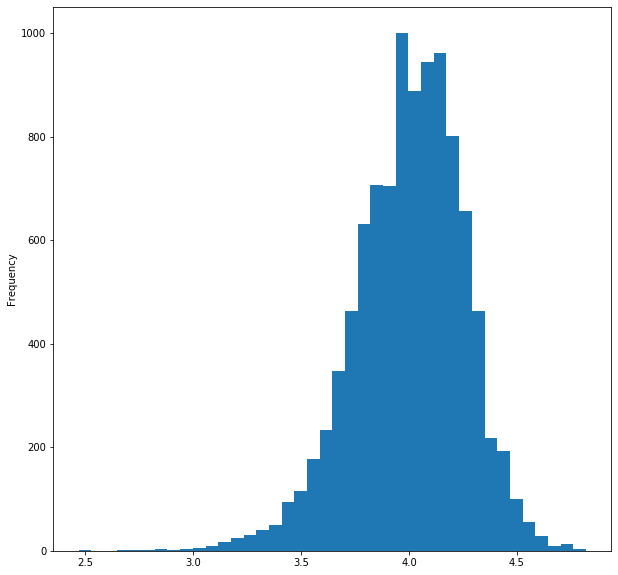

In [34]:
df.average_rating.plot(kind= 'hist', bins = 40, figsize = (10,10))
plt.show()

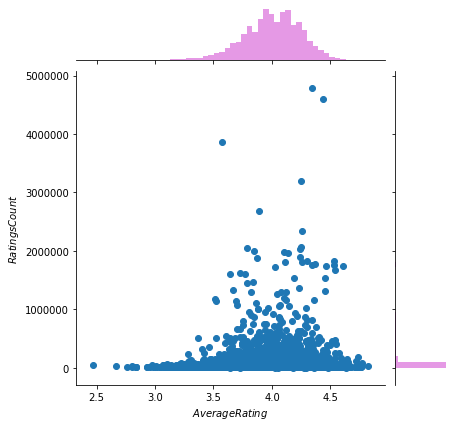

In [35]:
g = sns.jointplot(x="average_rating", y="ratings_count", data=df, kind="scatter", color="m")
g.plot_joint(plt.scatter, linewidth=1)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Average Rating$", "$Ratings Count$")

In [36]:
spark = SparkSession\
        .builder\
        .appName("BookRecommender")\
        .getOrCreate()

In [64]:
ratings = spark.read.text("hdfs:/tmp/ratings.hdfs.csv").rdd

In [69]:
print(ratings.take(5))

[Row(value='book_id,user_id,rating'), Row(value='1,314,5'), Row(value='1,439,3'), Row(value='1,588,5'), Row(value='1,1169,4')]


In [70]:
partitions = ratings.map(lambda row: row.value.split(","))

In [71]:
header = partitions.first()
ratingsRDD = partitions.filter(lambda line: line != header)

In [72]:
ratings_final_RDD = ratingsRDD.map(lambda p: Row(bookId= int(p[0]), userId= int(p[1]), rating=int(p[2])))

In [73]:
ratingsDF = spark.createDataFrame(ratings_final_RDD)

In [74]:
(training, test) = ratingsDF.randomSplit([0.8, 0.2])

In [75]:
# Alternating Least Square algorithm for recommendation
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="bookId", ratingCol="rating",
              coldStartStrategy="drop")

In [78]:
model = als.fit(training)

In [ ]:
# Generate top 10 book recommendations for each user
bookRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each book
userRecs = model.recommendForAllItems(10)

In [ ]:
# Show the top 10 book recommendations for each user
bookRecs.show()

In [ ]:
# Show the top 10 user recommendations for each book
userRecs.show()

In [ ]:
# Store the generated recommendations in hdfs
bookRecs.repartition(1).write.option("header", "true").json("../../tmp/bookRecs.json")
userRecs.repartition(1).write.option("header", "true").json("../../tmp/userRecs.json")

In [29]:
# KNN recommendation algorith using cosine similarity index to generate recommendations to be displayed on the WebUI

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['authors'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [30]:
# Create list of books
book_titles = df['title']
book_ids = pd.Series(df.index, index=df['title'])

In [31]:
# Reference: https://www.kaggle.com/zygmunt/goodbooks-10k

# Top 10 book recommendation function
def recommendBooks(book_name):
    bookId = book_ids[book_name]
    similarity_score = list(enumerate(cosine_sim[bookId]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    similarity_score = similarity_score[1:11] # creates array of top 10 books based on cosine similarity
    book_index = [i[0] for i in similarity_score]
    return book_ids[book_index].tolist()

In [32]:
booksRec = recommendBooks(titles[0])

In [33]:
recommendationDict = {}
recommendationDict.update({'Book_Title':titles[0],'Recommendations':(booksRec)})

In [34]:
f = open("recommendation.json","w")
f.write( str(recommendationDict) )
f.close()

In [35]:
from_path = 'recommendation.json'
to_path ='../../tmp/recommendations.hdfs.json'
pyhdfs.put(from_path, to_path)

In [ ]:
(ret, out, err)= run_cmd(['hdfs', 'dfs', '-copyToLocal', 'hdfs:/tmp/recommendations.hdfs.json', '.json'])

In [37]:
# Evaluate the ALS model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))


Root-mean-square error = 0.9080465255479093


In [38]:
spark.stop()